# Introduction


Data are pulled in as large files for ingest. These are external to the
repo folder so as not to bog it down (as repo size is constrained).
From this point there is an *ingest* process and a second process 
described below under the heading **Profiles**. 


To focus on *ingest* for a moment: The idea is to streamline the source
datasets by reducing clutter and cutting out a time window, say one month.
This notebook will start by considering a two year time range from 
1-JAN-2021 through 31-DEC-2022. From there we will focus on shorter
sub-ranges, typically a month in duration or less.

### Inbound data structure



There are two levels of source data time resolution: 1-minute average sampling
and full resolution sampling; which amounts to about 1 sample per second. 
The 1-minute-per-sample data will be smoother via 
averaging with the tradeoff of coarser depth resolution.


Again: Inbound data from OOI is kept outside this repo: In its own `/data/rca` 
folder. This inbound data folder structure is as follows:



```
$HOME/../data/rca/
                  OregonSlopeBase/
                                  platform/                (pc01a)
                                           [missing: velocity]
                                  profiler/                (sf01a)
                                           par/    
                                           do/
                                           vel/
                                           ctd/
                                           fluor/
                                           nitrate/
                                           pco2/
                                           ph/
                                           spkir/
                                           fullres_ctd/ etcetera
                  OregonOffshore/
                                  platform/                (pc01b)
                                  profiler/                (sf01b)
                  AxialBase/ 
                                  platform/               (pc03a)
                                  profiler/               (sf03a)

```

Please note that 1-minute-sample data goes into folders with no prefix; and 
full resolution (1-second-sample) data folders have the `fullres_` prefix 
as in `fullres_ctd`.


There are two resources for shallow profiler data:


- [Ocean Observatories Initiative **Data Explorer**](https://dataexplorer.oceanobservatories.org/)
- [Interactive Oceans **Data Portal**](https://interactiveoceans.washington.edu) which is specific to the Regional Cabled Array

### Terms used


* Regional Cabled Array (RCA): A cabled observatory on the sea floor and in select locations rising up through the water column: off the coast of Oregon
* Site: A location in the RCA
* Platform: A mechanical structure -- static or mobile -- at a site
* Instrument: A device fastened to a platform that carries one or more sensors
* Sensor: A device that measures some aspect of the ocean like pH or temperature
* Stream: Data produced by a sensor as part of an instrument located on a platform at a site in the RCA
* Profiler 'Oregon Slope Base'
* Profiler 'Axial Base' PN3A 
* Profiler 'Oregon Offshore' (shared with the OSU Endurance array)

#### Sensor dictionary with abbreviations


- This table is alphabetized by short abbreviation for the moment


- The instrument name corresponds to the folder structure given above


- Spectral irradiance is abbreviated `spkir` in the OOI nomenclature and this
is retained here. The instrument brings in seven spectral channels (sensors)
with wavelengths in *nm* as indicated.


```
Short     Sensor                Name used     Instrument     Sensor operates
Abbrev.                         here          folder name
-----     ------                -------       ----------     -----------
A         Chlorophyll-A         chlora        fluor          continuous
B         backscatter           backscatter   fluor          continuous
C         CDOM                  cdom          fluor          continuous
D         Density               density       ctd            continuous
E[]       Spec'r optical abs    oa            spec           ? (83 channels)
F[]       Spec'r beam atten     ba            spec
G         pCO2                  pco2          pco2           midnight/noon descent
H         pH                    ph            ph             midnight/noon descent
I         Spectral Irradiance   spkir412nm    spkir          ?
                                spkir443nm
                                spkir490nm
                                spkir510nm
                                spkir555nm
                                spkir620nm
                                spkir683nm
K         Conductivity          conductivity  ctd            continuous
N         Nitrate               nitrate       nitrate        midnight/noon ascent
P         PAR                   par           par            continuous
Q         pressure              pressure      ctd            continuous
O         dissolved oxygen      do            do             continuous
S         salinity              salinity      ctd            continuous
T         temperature           temp          ctd            continuous
U         velocity east         veast         current        continuous:
V         velocity north        vnorth                           from platform
W         velocity up           vup                              looking up
```

### Data download


As noted above: [OOI](https://oceanobservatories.org) 
provides data access via the [Data Explorer](https://dataexplorer.oceanobservatories.org/).
An alternative resource particular to the *OOI cabled array* is the
[Cabled Array data server](https://interactiveoceans.washington.edu).
This site is oriented towards built-in data exploration and is very educator-friendly. 


#### Example download


- [Data access page in the Data Explorer](https://dataexplorer.oceanobservatories.org/#go-to-data-access)
- Access Array Data, Oregon Margin, Profiling Assets, All Instrument Types, All Parameters, Go
    - A very dense page with charts, tabs, multiple scroll bars and so forth
    - Exploration of the various tabs encouraged
        - **Data**, **Inventory**, **Downloads**, **Annotations**, **Deployments**
    - > **Downloads** tab
    - Full resolution data: 1 second per sample
        - Choose link '*full resolution downloads*'
        - Page of fluorometer datasets in deployment sequence: time ranges shown
        - Select Downloads > THREDDS Catalog > Dataset > page listing files
        - Deployment 8, FLORT for the triplet
        - Check the time range in the filename for best match to March 2021
        - Click to go to yet another page, this one for "ACCESS" and multiple choices
            - Select HTTPServer to download the NetCDF data file: 600+ MB
    - 1Min resolution: 1 minute per sample
        - Green **Download** button for various streams / sensors 
        - Three format options: ERDDAP (+ 3 sub-options), CSV and NetCDF
            - NetCDF URL gives a shareable download link
            - NetCDF **Download** button > 1Min downsampled data
                - These datasets extend over the full OOI program duration: 2014 to present
            - Data description text + chart symbol (left) produces a curtain plot


Full resolution data is sub-divided into consecutive time ranges called "deployments". 
The resulting NetCDF files have these distinctions compared to the 1Min data:


- Data is sampled at about one sample per second
- Sensors are combined in NetCDF files
    - For example a CTD file includes salinity, temperature, pressure, density and conductivity
- The data files are much larger on average
- The sample dimension is `obs` (observation number) rather than `row`
    - However the swap procedure is the same: Swap in `time`


#### Code note


This notebook refers to functions in the companion module file `data.py`.

In [1]:
from matplotlib import pyplot as plt

from data import *

print('\nJupyter Notebook running Python {}'.format(sys.version_info[0]))


Jupyter Notebook running Python 3


```
operating on '../../../data/rca/OregonSlopeBase/profiler/ctd/ooi-rs01sbps-sf01a-2a-ctdpfa102_6974_57e0_dbda.nc' and so on
```

In [2]:
###### Uncomment the line of code below and run this cell once per each month-long in-repo sensor data file
# Example output file: 'axb_nitrate_jan22_nitrate.nc' gives site, instrument, sensor and time range
# spkir requires only one output file; but seven sensor re-names: To 'spkir412nm' etcetera.

# if not ReformatDataFile(False): print('ReformatDataFile() returned False')

#### Test dataset

On 10/16/23 the 1min datasets (repo-external /data folder) from OOI were processed for storage
and use in this repository. The file naming convention is 


**`<site>_<instrument>_<month>_<sensor>.nc`**.


Hence for the Oregon Slope Base profiler we have `osb_spkir_jan22_spkir412nm.nc` using the OOI abbreviation
for spectral irradiance **`spkir`**. The instrument is spkir and the sensor is spkir412nm. 



Note that the sensor and instrument are the same in this case; 
but in a confusing twist: Spectral irradiance is expressed as seven wavelengths. So that is a special 
case in the subsequent data dictionary build. Simpler sensors are `par`, `do`, `nitrate`, `pco2` and `ph`.
For all of these the instrument and sensor names are the same. 
In the case of the fluorometer, current velocity and CTD `instruments` there are multiple sensors:
The sensor name is not the same as the instrument.


Data reduction:


- Jan 1 to Feb 1 2021 in prog
- Apr 1 to May 1 2021 done
- Jul 1 to Aug 1 2021 done
- Oct 1 to Nov 1 2021 in prog
- Jan 1 to Feb 1 2022 done


In [23]:
from shallowprofiler import sensors

date_id = 'apr21'
site_id = 'osb'

data_file_list = []
for s in sensors:
    data_file_list.append(site_id + '_' + s[1] + '_' + date_id + '_' + s[0] + '.nc')   # example: 'osb_ctd_jul21_temperature.nc'


Jupyter Notebook running Python 3


#### Data review


The above cell generates time-bounded NetCDF measurement data files for in-repo output. 
To review these files and their *XArray Dataset data variable* names: Activate and run the
following code. The cell below captures these names into a list of lists.
    
```
data_prefix = '../data/'
for f in data_file_list:
    ds = xr.open_dataset(data_prefix + f)
    print(ds)
    r = input('enter to continue')
```

In [1]:
# The relative path to the data files from the Notebooks folder is up one level, then to the data folder
data_prefix = '../data/'

# The data variables corresponding to the jan22_data files defined above
month_data_vars = [
    ['pressure'],['temperature'],['density'], ['salinity'], ['conductivity'],
    ['fdom'], ['chlora'], ['bb'],
    ['spkir412nm', 'spkir443nm', 'spkir490nm', 'spkir510nm', 'spkir555nm', 'spkir620nm', 'spkir683nm'],
    ['nitrate'],
    ['pco2'],
    ['do'],
    ['par'],
    ['ph'],
    ['up'], ['east'], ['north']
    ]

## Profiles


The final task of this notebook is to produce a table of profile metadata. 


Profile timing is driven by the RCA engineering system, producing some variability in profile
timing. Also shallow profilers occasionally go out of service. Using profile time/depth data we
produce a table of timestamps corresponding to 3-part profile cycles: Ascent, Descent and Rest. 
This table is used in subsequent analysis to isolate individual profiles.


The following cell illustrates a typical day of profiling cycles.


- The time scale for January 10 is in UTM hours
- Nine profiles are run, two of which are noticeably longer in duration
- The two longer profiles at midnight and noon associate with nitrate, pCO2 and pH measurement
    - These have built-in pauses for equilibration during descent
- During the *rest* intervals the profiler is secured in an anchored platform
    - The platform has its own set of instruments

Some relevant-in-time profiles


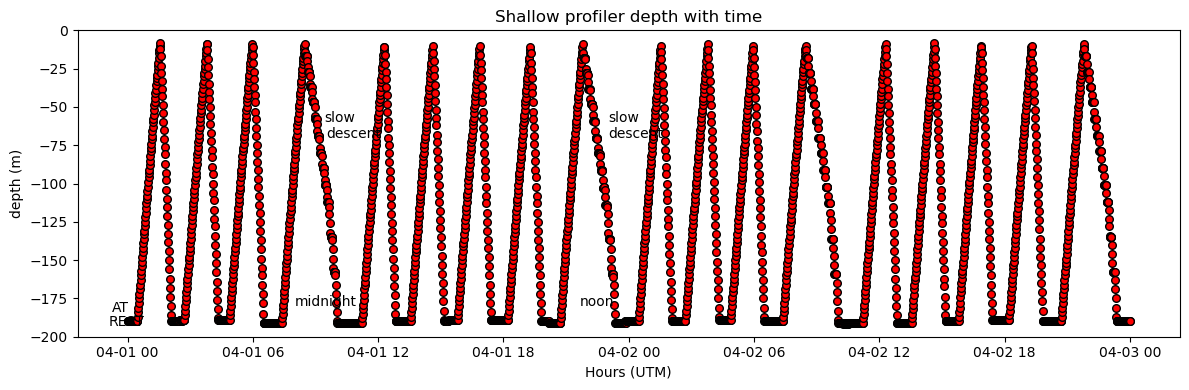

In [37]:
# flag this cell should correspond to a chosen date range; it is hardcoded at the moment

def ProfilerDepthChart(t0, t1, fnm, annotate=False):
    ds = xr.open_dataset(fnm).sel(time=slice(dt64(t0), dt64(t1)))
    fig, axs = plt.subplots(figsize=(12,4), tight_layout=True)
    axs.plot(ds.time, ds.z, marker='.', ms=11., color='k', mfc='r', linewidth='.0001')
    axs.set(ylim = (-200., 0.), title='Shallow profiler depth with time', ylabel='depth (m)', xlabel='Hours (UTM)')
    if annotate:
        axs.text(dt64('2021-03-31 23:15'), -184, 'AT')
        axs.text(dt64('2021-03-31 23:05'), -193, 'REST')
        axs.text(dt64('2021-04-01 08'), -180, 'midnight')
        axs.text(dt64('2021-04-01 21:40'), -180, 'noon')
        axs.text(dt64('2021-04-01 09:25'), -60, 'slow')
        axs.text(dt64('2021-04-01 09:30'), -70, 'descent')
        axs.text(dt64('2021-04-01 23:00'), -60, 'slow')
        axs.text(dt64('2021-04-01 23:00'), -70, 'descent')
    return True

ProfilerDepthChart('2021-04-01', '2021-04-03', data_prefix + data_file_list[0], True)  # index [0] is arbitrary; any dataset will include z data

print('Some relevant-in-time profiles')

In [31]:
def WriteProfile(date_id):
    fnm = '../data/osb_ctd_' + date_id + '_pressure.nc'                       
    a0, a1, d0, d1, r0, r1 = ProfileGenerator(fnm, 'z', True)
    # last 2 days chart check: xr.open_dataset(fnm)['z'][-1440*2:-1].plot()
    if not ProfileWriter('../profiles/osb_profiles_' + date_id + '.csv', a0, a1, d0, d1, r0, r1): print('ProfileWriter() is False')
    
    
for date_id in ['apr21', 'jul21', 'jan22']: WriteProfile(date_id)               # !!!!! hard coded flag

Sanity: -190.0 is initial depth
there are 270 ascent starts
there are 270 descent starts
there are 271 rest starts
a0: 270    a1: 270
d0: 270    d1: 270
r0: 270    r1: 270
Sanity: -191.0 is initial depth
there are 279 ascent starts
there are 279 descent starts
there are 280 rest starts
a0: 279    a1: 279
d0: 279    d1: 279
r0: 279    r1: 279
Sanity: -191.0 is initial depth
there are 279 ascent starts
there are 279 descent starts
there are 279 rest starts
a0: 279    a1: 279
d0: 279    d1: 279
r0: 279    r1: 279


#### How to use profile files

- Read the file into a pandas Dataframe
- Each row is a Rest --- Ascent --- Descent phase sequence
    - Each phase has a start and an end: For a total of six events
        - There is degeneracy: r1 == a0, a1 == d0, and mostly d1 == the next row's r0
    - Each entry for these six events is a triple (i, t, z)
        - i is an index from the source file; usually ignore this
        - t is the time of the event; important
        - z is the depth of the event
            - for a1/d0 this will indicate if the profile approached the surface
    - Consequently each row has 18 columns
    
Suppose the idea is to make a depth plot of temperature for a particular profile. Select out this
profile and slice the source data using a time range given as a0 to a1. See the next notebook 
for examples.


...April 2021 Oregon Slope Base daily profiles...


True

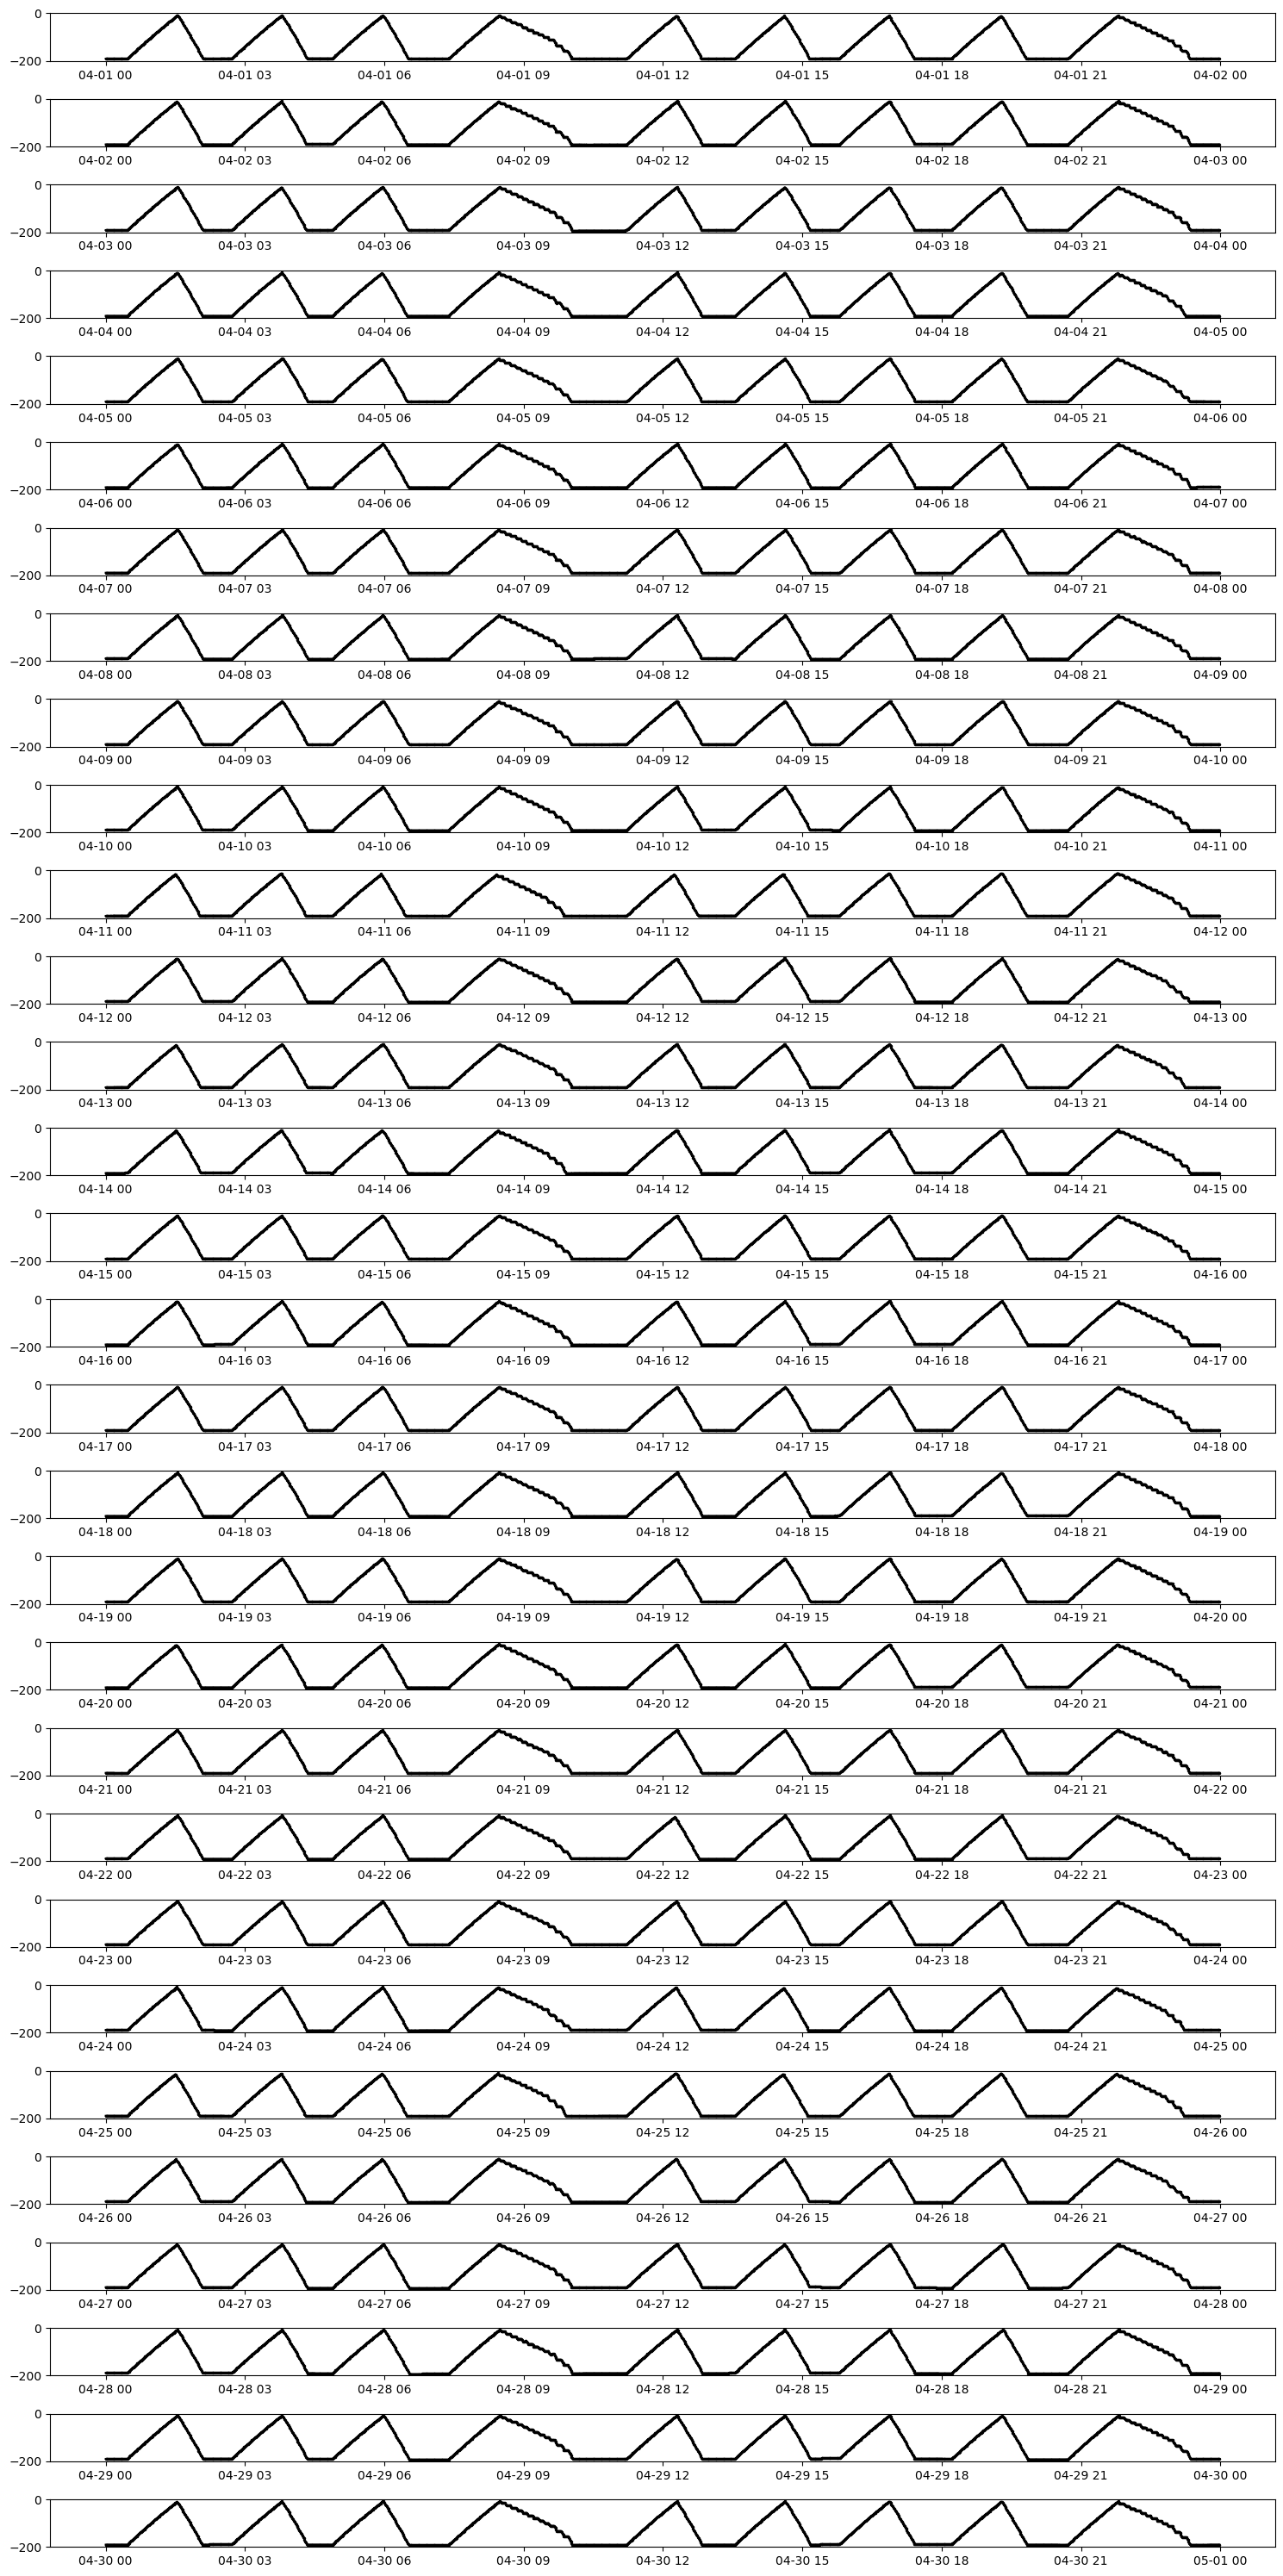

In [36]:
#### visual on one month of profiles
# !!!!! hard coded flag
# !!!!! flag move to charts

def VisualizeOneMonthOfProfiles(date_id, n_days, year_id, month_id, month_name, site_name):
    ds = xr.open_dataset('./../data/osb_ctd_' + date_id + '_pressure.nc')
    fig, axs = plt.subplots(n_days, 1, figsize=(15,n_days), tight_layout=True)

    for i in range(n_days):
        daystring = str(i+1) if i > 8 else '0' + str(i+1)
        time0 = dt64(year_id + '-' + month_id + '-' + daystring + 'T00:00:00')
        time1 = dt64(year_id + '-' + month_id + '-' + daystring + 'T23:59:59')
        dsDay = ds.sel(time=slice(time0, time1))
        axs[i].plot(dsDay.time, dsDay.z, marker='.', markersize=3., color='k')
        axs[i].set(ylim = (-200., 0.))

    print('...' + month_name + ' ' + str(year_id) + ' ' + site_name + ' daily profiles...')
    return True


VisualizeOneMonthOfProfiles('apr21', 30, '2021', '04', 'April', 'Oregon Slope Base')


#### Comment on profile phase durations


```
  Ascents:   67.4 +-3.0  minutes
  Descents:  vary depending: midnight/noon descents are slow (70 minutes); otherwise quick (20 minutes)
  Rests:     vary with descent, 30 / 60 minutes
```
